# Estimating MI by noise contrastive method (InfoNCE)

## Setup

The following cell imports the necessary packages:

In [46]:
import torch
import torch.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
import argparse
from src.utils import *
from src.mi_estimators import *
from torch.utils.tensorboard import SummaryWriter

Set random seed for reproducibility.

In [47]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
torch.set_default_tensor_type(FloatTensor)

Specify the hyper-parameters:

In [48]:
parser = argparse.ArgumentParser()
parser.add_argument("--rho", type=float, default=0.9, help="coefficient of Gaussian")
parser.add_argument("--d", type=int, default=20, help="dimension of X & Y")
parser.add_argument("--sample_size", type=int, default=400, help="sample size")
parser.add_argument("--gamma", type=float, default=1e-10, help="clipping parameter")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--batch_size", type=int, default=40, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-3, help="adam: learning rate")
parser.add_argument("--hidden_dim", type=int, default=100, help="Hidden dimension")
parser.add_argument("--hidden_layer", type=int, default=2, help="the number of hidden layers")
parser.add_argument("--ma_rate", type=float, default=0.1, help="move average rate")
parser.add_argument("--ma_ef", type=float, default=1, help="move average ef")
parser.add_argument("--exc", type=int, default=1, help="whether exclude the data sample from the reference samples")
parser.add_argument("--reg", type=int, default=1, help="if apply regularization")
parser.add_argument("--n_epoch", type=int, default=2000, help="number of epochs of training")
parser.add_argument("--n_iters_1epoch", type=int, default=10, help="number of epochs of training")

opt, unknown = parser.parse_known_args()
opt.n_iters = opt.n_epoch * opt.n_iters_1epoch
ma_rate = 0.01  # moving average rate

In [49]:
continue_train = False  # set to True to continue to train
load_available = True # set to False to prevent loading previous results
overwrite = False  # set to True to overwrite previously stored results

In [50]:
data = GaussianData(opt.sample_size, d=opt.d, rho=opt.rho)
X, Y, XY, Ground_truth = data.X, data.Y, torch.cat((data.X, data.Y), dim=1), data.mutual_information()

## Model

In [51]:
name = f'./results/InfoNCE_dim{opt.d}_reg{opt.reg}'   # filename
chkpt_name = name+'.pt'      # checkpoint

from datetime import datetime
TIMESTAMP = "{0:%Y-%m-%dT%H-%M-%S/}".format(datetime.now())
writer = SummaryWriter(f'./results/log/InfoNCE_dim{opt.d}_reg{opt.reg}/{TIMESTAMP}')
discriminator = Net(input_size=opt.d*2, hidden_layers=opt.hidden_layer, hidden_size=opt.hidden_dim)

# move NN model to GPU if GPU is available
if cuda:
    discriminator.cuda()

# Adam optimizer
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [52]:
def infonce_loss(net, x_samples, y_samples, writer=None, epoch=None, reg=False):
    sample_size = x_samples.shape[0]
    x_tile = x_samples.unsqueeze(0).repeat((sample_size, 1, 1))
    y_tile = y_samples.unsqueeze(1).repeat((1, sample_size, 1))

    T0 = net(torch.cat([x_samples,y_samples], dim = -1))
    T1 = net(torch.cat([x_tile, y_tile], dim = -1))
    a = T0.mean()
    b = T1.logsumexp(dim = 1).mean() - np.log(sample_size)
    if reg:
        lower_bound = a - b - b**2
    else:
        lower_bound = a - b

    if writer is not None:
        writer.add_scalar('a', a, epoch)
        writer.add_scalar('b', b, epoch)
        writer.add_scalar('log ratio', a-b-np.log(sample_size), epoch)
    return lower_bound

In [53]:
def infonce_exc_loss(net, x_samples, y_samples, writer=None, epoch=None, reg=False):
    sample_size = x_samples.shape[0]
    x_tile = x_samples.unsqueeze(0).repeat((sample_size, 1, 1))
    y_tile = y_samples.unsqueeze(1).repeat((1, sample_size, 1))
    mask =  torch.ones([sample_size]).diag().unsqueeze(-1).bool().cuda()
    T0 = net(torch.cat([x_samples,y_samples], dim = -1))
    T1 = net(torch.cat([x_tile, y_tile], dim = -1))
    a = T0.mean()
    b = T1[~mask].reshape(-1, sample_size-1, 1).logsumexp(dim = 0).mean() - np.log(sample_size-1)

    if reg:
        lower_bound = a - b - b**2
    else:
        lower_bound = a - b

    if writer is not None:
        writer.add_scalar('a', a, epoch)
        writer.add_scalar('b', b, epoch)
    return lower_bound

Load previous results.

In [54]:
# load_available = True # set to False to prevent loading previous results
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    mi_list = checkpoint['mi_list']
    model_state = checkpoint['model_state']
    discriminator.load_state_dict(model_state)
    print('Previous results loaded.')
else:
    mi_list = [] # storing the mi estimation of each iteration

Previous results loaded.


## Training

Since maximizing the infoNCE bound over $f$ attains the mutual information

\begin{align}
I(X\wedge Y) = \sup_{f} I_{\text{infoNCE}}(f),
\end{align}

we train the neural network to minimize the loss $-I_{\text{infoNCE}}(f)$. The optimal solution $f$ satisfies

\begin{align}
f(x,y)=\log \frac{p_{Y|X}(y|x)}{p_{Y}(y)} + c \quad \forall x\in \mathcal{X}, y \in \mathcal{Y}
\end{align}

for any constant $c$.

The following cell train the neural network using the data samples.

In [55]:
# continue_train = True  # set to True to continue to train
if continue_train:
    iter_ = 0
    # for i in range(opt.n_epoch):
    #     # idx = torch.randperm(opt.sample_size)
    #     idx = np.random.permutation(opt.sample_size)
    #     # idx_X, idx_Y = randerange(opt.sample_size)
    #     for j in range(opt.n_iters_1epoch):
    #         batch_idx = idx[j::opt.n_iters_1epoch]
    for i in range(opt.n_epoch*opt.n_iters_1epoch):
        data_joint = resample(XY, batch_size=opt.batch_size)
            # train_x = X[batch_idx]
            # train_y = Y[batch_idx]
        train_x = data_joint[:,0:opt.d]
        train_y = data_joint[:,opt.d:]

        optimizer_D.zero_grad()
        loss = -infonce_loss(discriminator, train_x, train_y, reg=opt.reg) # negative infonce_bound as the loss
        loss.backward()

        optimizer_D.step()
        with torch.no_grad():
            # mi_est = infonce_loss(discriminator, X, Y, writer, i)
            mi_est = infonce_loss(discriminator, X, Y)
        mi_list.append(mi_est.item())
        writer.add_scalar('mi_list', mi_est.item(), i)
        writer.add_scalar('loss', loss, i)
        iter_ += 1

        if i%1000==0:
            print("Iternation: %d, loss: %f, mi_est: %f"%(iter_, loss.item(), mi_est))
            fig = plot_fig(discriminator, X, Y, d= opt.d if opt.d<6 else 6 )
            writer.add_figure('heatmap', fig, i)
            writer.add_histogram('first layer', discriminator.fc[0].weight.data, i)
            writer.add_histogram('second layer', discriminator.fc[1].weight.data, i)
            writer.add_histogram('third layer', discriminator.fc[2].weight.data, i)

            writer.add_histogram('first layer (grad)', discriminator.fc[0].weight.grad.data, i)
            writer.add_histogram('second layer (grad)', discriminator.fc[1].weight.grad.data, i)
            writer.add_histogram('third layer (grad)', discriminator.fc[2].weight.grad.data, i)


# writer.add_graph(discriminator, (XY,))
writer.close()

In [34]:
# overwrite = True  # set to True to overwrite previously stored results
if overwrite or not os.path.exists(chkpt_name):
    model_state = discriminator.state_dict()
    torch.save({
        'mi_list': mi_list,
        'model_state': model_state
    }, chkpt_name)
    writer.close()
    print('Current results saved.')

Current results saved.


## MI estimates

Use moving average to smooth the estimated MI in each training iteration.

In [43]:
mi_copy = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy[k] = (1-ma_rate) * mi_copy[k-1] + ma_rate * mi_copy[k]

Plot the MI estimation curve against the training iteration, together with the ground truth.

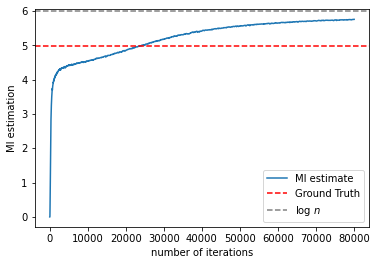

In [45]:
plt.plot(mi_copy, label='MI estimate')
plt.axhline(Ground_truth,label='Ground Truth',linestyle='--',color='red')
plt.axhline(np.log(opt.sample_size),label='log $n$',linestyle='--',color='grey')
# for t in range(len(mi_copy)):
#     if (mi_copy[t]>.8*Ground_truth):
#         plt.axvline(t,label='80% reached',linestyle=':',color='green')
#         break
plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.legend()
plt.savefig(f'./results/InfoNCE_dim{opt.d}_reg{opt.reg}.pdf')

In [58]:
def plot_subfigure(net, X, Y, dimX, dimY, x0=None, y0=None, xmin=-5, xmax=5, ymin=-5, ymax=5, xgrids=50, ygrids=50, ax=None, show_details=True):
    """
    The inputs should be X and Y, which are the coordinates of the points.

    net should be a neural network with Tensor inputs.
    """

    if  x0 == None:
        x0 = np.zeros((1, X.shape[1]))
    if y0 == None:
        y0 = np.zeros((1, Y.shape[1]))

    x, y = np.mgrid[xmin:xmax:xgrids * 1j, ymin:ymax:ygrids * 1j]
    with torch.no_grad():
        z = (net(
            torch.cat((torch.Tensor((np.arange(X.shape[-1]) == dimX).reshape(1, -1) *
                    x.reshape(-1, 1) + x0).to(DEVICE),
            torch.Tensor((np.arange(X.shape[-1]) == dimY).reshape(1, -1) *
                    y.reshape(-1, 1) + y0).to(DEVICE),
        ),dim=-1)).reshape(x.shape).cpu())
    if ax is None:
        ax = plt.gca()

    im = ax.pcolormesh(x, y, z, vmin=-40, vmax=5, cmap="RdBu_r", shading="auto")
    # ax.figure.colorbar(im)
    if show_details:
        ax.figure.colorbar(im)
        ax.set(xlabel="$x^{{({0})}}-x_0^{{({0})}}$",
                ylabel="$x^{{({0})}}-x_0^{{({0})}}$",
                title=r"Heatmap of $t(x,y)$")
    return im

def plot_fig(net, X, Y, d=6):
    f, axs = plt.subplots(nrows=d,ncols=d,sharex=True, sharey=True)
    for i in range(d):
        for j in range(d):
            im = plot_subfigure(net, X, Y, dimX=i, dimY=j, x0=None, y0=None, xmin=-5, xmax=5, ymin=-5, ymax=5, xgrids=50, ygrids=50, ax=axs[i, j], show_details=False)
    f.colorbar(im, ax=axs.ravel().tolist())
    return f

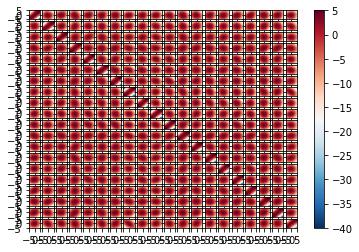

In [61]:
heatmap = plot_fig(discriminator, X, Y, d=6)
# plt.savefig(f'./results/heatmap_InfoNCE_dim{opt.d}_reg{opt.reg}.pdf')

## InfoNCE w\o datasamples

In [16]:
name = f'./results/InfoNCE_exc_dim{opt.d}_reg{opt.reg}'   # filename
chkpt_name = name+'.pt'      # checkpoint
# opt.reg = 0
from datetime import datetime
TIMESTAMP = "{0:%Y-%m-%dT%H-%M-%S/}".format(datetime.now())
writer = SummaryWriter(f'./results/log/InfoNCE_exc_dim{opt.d}_reg{opt.reg}/{TIMESTAMP}')
discriminator2 = Net(input_size=opt.d*2, hidden_layers=opt.hidden_layer, hidden_size=opt.hidden_dim)

# move NN model to GPU if GPU is available
if cuda:
    discriminator2.cuda()

# Adam optimizer
optimizer_D = torch.optim.Adam(discriminator2.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [17]:
# load_available = True # set to False to prevent loading previous results
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    mi_list = checkpoint['mi_list']
    model_state = checkpoint['model_state']
    discriminator2.load_state_dict(model_state)
    print('Previous results loaded.')
else:
    mi_list = [] # storing the mi estimation of each iteration

In [18]:
# continue_train = True  # set to True to continue to train
if continue_train:
    for i in range(opt.n_epoch*opt.n_iters_1epoch):
        data_joint = resample(XY, batch_size=opt.batch_size)
        train_x = data_joint[:,0:opt.d]
        train_y = data_joint[:,opt.d:]

        optimizer_D.zero_grad()
        loss = -infonce_exc_loss(discriminator2, train_x, train_y, reg=opt.reg) # negative infonce_bound as the loss
        loss.backward()

        optimizer_D.step()
        with torch.no_grad():
            mi_est = infonce_exc_loss(discriminator2, X, Y, writer, i)
        mi_list.append(mi_est.item())
        writer.add_scalar('mi_list', mi_est.item(), i)
        writer.add_scalar('loss', loss, i)

        if i%1000==0:
            print("Iternation: %d, loss: %f, mi_est: %f"%(i, loss.item(), mi_est))
            fig = plot_fig(discriminator2, X, Y, d=opt.d if opt.d<6 else 6)
            writer.add_figure('heatmap', fig, i)
            writer.add_histogram('first layer', discriminator2.fc[0].weight.data, i)
            writer.add_histogram('second layer', discriminator2.fc[1].weight.data, i)
            writer.add_histogram('third layer', discriminator2.fc[2].weight.data, i)

            writer.add_histogram('first layer (grad)', discriminator2.fc[0].weight.grad.data, i)
            writer.add_histogram('second layer (grad)', discriminator2.fc[1].weight.grad.data, i)
            writer.add_histogram('third layer (grad)', discriminator2.fc[2].weight.grad.data, i)

# writer.add_graph(discriminator2, (XY,))
writer.close()

Iternation: 0, loss: 0.026040, mi_est: -0.002494
Iternation: 1000, loss: -5.127612, mi_est: 5.160129
Iternation: 2000, loss: -11.372650, mi_est: 5.231303
Iternation: 3000, loss: -12.064240, mi_est: 6.631378
Iternation: 4000, loss: -9.311867, mi_est: 5.857926
Iternation: 5000, loss: 28.395718, mi_est: 3.251190
Iternation: 6000, loss: -17.928013, mi_est: 6.896912
Iternation: 7000, loss: -25.686893, mi_est: 7.904385
Iternation: 8000, loss: -35.631805, mi_est: 8.406637
Iternation: 9000, loss: -1.615753, mi_est: 8.793091
Iternation: 10000, loss: -26.837381, mi_est: 9.671806
Iternation: 11000, loss: -28.242912, mi_est: 8.816132
Iternation: 12000, loss: -39.168335, mi_est: 10.215359
Iternation: 13000, loss: -31.787321, mi_est: 9.407356
Iternation: 14000, loss: -24.669666, mi_est: 11.416431
Iternation: 15000, loss: -40.059082, mi_est: 10.831223
Iternation: 16000, loss: -12.485273, mi_est: 11.424274
Iternation: 17000, loss: -34.446110, mi_est: 12.444870
Iternation: 18000, loss: -45.216640, mi_e

In [19]:
mi_copy2 = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy2[k] = (1-ma_rate) * mi_copy2[k-1] + ma_rate * mi_copy2[k]

In [20]:
# overwrite = True  # set to True to overwrite previously stored results
if overwrite or not os.path.exists(chkpt_name):
    model_state = discriminator2.state_dict()
    torch.save({
        'mi_list': mi_list,
        'model_state': model_state
    }, chkpt_name)
    writer.close()
    print('Current results saved.')

Current results saved.


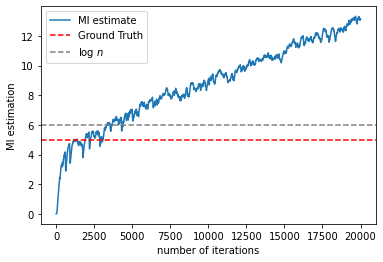

In [22]:
plt.plot(mi_copy2, label='MI estimate')
plt.axhline(Ground_truth,label='Ground Truth',linestyle='--',color='red')
plt.axhline(np.log(opt.sample_size),label='log $n$',linestyle='--',color='grey')
# for t in range(len(mi_copy)):
#     if (mi_copy[t]>.8*Ground_truth):
#         plt.axvline(t,label='80% reached',linestyle=':',color='green')
#         break
plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.legend()
plt.savefig(f'./results/InfoNCE_exc_dim{opt.d}_reg{opt.reg}.pdf')

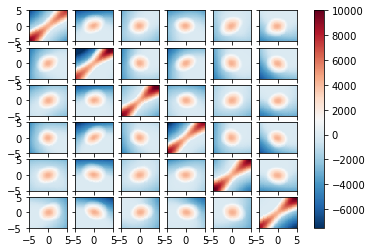

In [130]:
heatmap = plot_fig(discriminator2, X, Y, d=6)
plt.savefig(f'./results/heatmap_InfoNCE_exc_dim{opt.d}_reg{opt.reg}.pdf')

## Ground Truth Heapmap

In [62]:
def plot_subfigure_GT(net, X, Y, dimX, dimY, x0=None, y0=None, xmin=-5, xmax=5, ymin=-5, ymax=5, xgrids=50, ygrids=50, ax=None, show_details=True):
    """
    net: GT_logratio
    """
    if  x0 == None:
        x0 = np.zeros((1, X.shape[1]))
    if y0 == None:
        y0 = np.zeros((1, Y.shape[1]))
        
    x, y = np.mgrid[xmin:xmax:xgrids * 1j, ymin:ymax:ygrids * 1j]
    with torch.no_grad():
        z = (net(
            torch.Tensor((np.arange(X.shape[-1]) == dimX).reshape(1, -1) *
                    x.reshape(-1, 1) + x0).to(DEVICE),
            torch.Tensor((np.arange(X.shape[-1]) == dimY).reshape(1, -1) *
                    y.reshape(-1, 1) + y0).to(DEVICE),
        ).reshape(x.shape).cpu())
    if ax is None:
        ax = plt.gca()
    im = ax.pcolormesh(x, y, z, cmap="RdBu_r", shading="auto", vmax=20, vmin=-200)
    if show_details:
        ax.figure.colorbar(im) 
        ax.set(xlabel="$x^{{({0})}}-x_0^{{({0})}}$",
                ylabel="$x^{{({0})}}-x_0^{{({0})}}$",
                title=r"Heatmap of $t(x,y)$")

    return im

In [66]:
def GT(x, y):
    mi = -0.5 * np.log(1 - opt.rho**2) * opt.d
    c = opt.rho / (2 * (1 - opt.rho**2))
    return mi + c * (2 * x * y - opt.rho *(x**2 + y**2)).sum(dim=1)

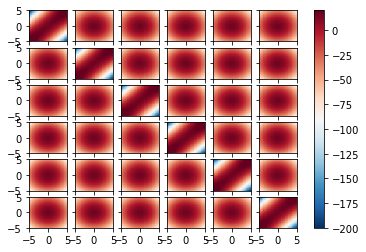

In [68]:
d = 6
DEVICE = "cuda"
f, axs = plt.subplots(nrows=d,ncols=d,sharex=True, sharey=True)
for i in range(d):
    for j in range(d):
        im = plot_subfigure_GT(GT, X, Y, dimX=i, dimY=j, x0=None, y0=None, xmin=-5, xmax=5, ymin=-5, ymax=5, xgrids=50, ygrids=50, ax=axs[i, j], show_details=False)

# plt.savefig(f'results/InfoNCE_trueref_heatmap_dim{opt.d}.pdf')
# im = plot_subfigure_GT(GT_logratio, X, Y, dimX=4, dimY=5, x0=None, y0=None, xmin=-5, xmax=5, ymin=-5, ymax=5, xgrids=50, ygrids=50, ax=axs[i, j], show_details=False)
f.colorbar(im, ax=axs.ravel().tolist())
plt.savefig(f'./results/GT_heatmap_dim{opt.d}.pdf')
plt.show()

## InfoNCE with GT reference distribution

In [20]:
discriminator3 = Net(input_size=opt.d*2, hidden_size=100)

# move NN model to GPU if GPU is available
if cuda:
    discriminator3.cuda()

# Adam optimizer
optimizer_D = torch.optim.Adam(discriminator3.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [21]:
name = f'./results/InfoNCE_knownref_dim{opt.d}'   # filename
chkpt_name = name+'.pt'      # checkpoint
writer = SummaryWriter(f'./results/log/InfoNCE_knownref_dim{opt.d}')


# load_available = True # set to False to prevent loading previous results
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    mi_list = checkpoint['mi_list']
    model_state = checkpoint['model_state']
    discriminator3.load_state_dict(model_state)
    print('Previous results loaded.')
else:
    mi_list = [] # storing the mi estimation of each iteration

In [22]:
def estimate_withGT(Net, jointdata, marginaldata):
    L = Net(jointdata).mean()
    L_ = discriminator3(marginaldata).reshape((jointdata.shape[0], jointdata.shape[0], -1)).logsumexp(1) - np.log(jointdata.shape[0])
    return L - L_.mean()

In [23]:
idx = torch.randperm(opt.sample_size)
data = GaussianData(opt.sample_size**2, d=opt.d, rho=opt.rho)
data2 = GaussianData(opt.sample_size*opt.batch_size, d=opt.d, rho=opt.rho)
ref_Y = data.Y
ref_X = X.repeat(opt.sample_size, 1)
ref_data = torch.cat((ref_X, ref_Y), dim=1)

# continue_train = True  # set to True to continue to train
_iter = 0
if continue_train:
    for i in range(opt.n_epoch):
        idx = torch.randperm(opt.sample_size)

        for j in range(opt.n_iters_1epoch):
            optimizer_D.zero_grad()
            batch_idx = idx[j::opt.n_iters_1epoch]
            batch_X = X[batch_idx]
            batch_Y = Y[batch_idx]

            batch_X_ref = X[batch_idx.unsqueeze(0).repeat(
                opt.sample_size, 1)]
            batch_Y_ref = data2.Y
            batch_Y_ref = batch_Y_ref.reshape((-1,) + batch_X_ref.shape[1:])
            # define the loss
            L = -discriminator3(torch.cat((batch_X, batch_Y),dim=1)).mean()
            L_ = discriminator3(torch.cat((batch_X_ref, batch_Y_ref), dim=-1)).reshape(
                    (opt.sample_size, batch_idx.shape[0],
                        -1)).logsumexp(1) - np.log(batch_Y_ref.shape[0])
            loss = L + L_.mean()
            loss.backward()

            optimizer_D.step()
            writer.add_scalar("Loss/train",
                                    loss.item(),
                                    global_step=_iter)
            writer.add_scalar("L", L.item(), global_step=_iter)
            writer.add_scalar("L_.mean()",
                                    L_.mean().item(),
                                    global_step=_iter)
            _iter += 1

            with torch.no_grad():
                mi_est = estimate_withGT(discriminator3, XY, ref_data)

            mi_list.append(mi_est.item())
            writer.add_scalar('mi_list', mi_est, _iter)
            writer.add_scalar('loss', loss, _iter)
            if _iter%500==0:
                print("Iternation: %d, loss: %f, mi_est: %f"%(_iter, loss.item(), mi_est))

writer.add_graph(discriminator3, (XY,))

Iternation: 500, loss: -665.835571, mi_est: 456.018829
Iternation: 1000, loss: -9209.822266, mi_est: 6776.464844
Iternation: 1500, loss: -34778.976562, mi_est: 25535.050781
Iternation: 2000, loss: -83923.773438, mi_est: 60833.148438
Iternation: 2500, loss: -156567.343750, mi_est: 113942.789062
Iternation: 3000, loss: -249548.250000, mi_est: 185848.718750
Iternation: 3500, loss: -386537.000000, mi_est: 277739.218750
Iternation: 4000, loss: -566278.687500, mi_est: 390238.500000
Iternation: 4500, loss: -686959.500000, mi_est: 524799.812500
Iternation: 5000, loss: -946937.812500, mi_est: 682045.625000
Iternation: 5500, loss: -1159350.125000, mi_est: 863011.500000
Iternation: 6000, loss: -1456032.000000, mi_est: 1069179.250000
Iternation: 6500, loss: -1791936.000000, mi_est: 1300582.625000
Iternation: 7000, loss: -2007175.500000, mi_est: 1559155.625000
Iternation: 7500, loss: -2407509.500000, mi_est: 1845497.375000
Iternation: 8000, loss: -2891269.500000, mi_est: 2160693.750000
Iternation: 

In [24]:
overwrite = True  # set to True to overwrite previously stored results
if overwrite or not os.path.exists(chkpt_name):
    model_state = discriminator3.state_dict()
    torch.save({
        'mi_list': mi_list,
        'model_state': model_state
    }, chkpt_name)
    writer.close()
    print('Current results saved.')

Current results saved.


In [25]:
mi_copy3 = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy3[k] = (1-ma_rate) * mi_copy3[k-1] + ma_rate * mi_copy3[k]

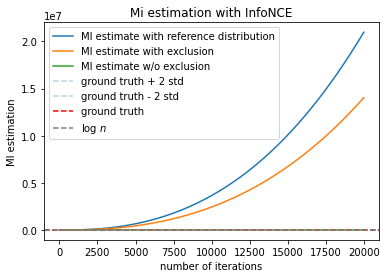

In [26]:
std = 0.183
plt.plot(mi_copy3, label='MI estimate with reference distribution')
plt.plot(mi_copy2, label='MI estimate with exclusion')
plt.plot(mi_copy, label='MI estimate w/o exclusion')

plt.axhline(Ground_truth+2*std,label='ground truth + 2 std',linestyle='--',color='lightblue')
plt.axhline(Ground_truth-2*std,label='ground truth - 2 std',linestyle='--',color='lightblue')
plt.axhline(Ground_truth,label='ground truth',linestyle='--',color='red')
plt.axhline(np.log(opt.sample_size),label='log $n$',linestyle='--',color='grey')

plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.title('Mi estimation with InfoNCE')
plt.legend()
# plt.savefig(f'results/InfoNCE_wo_datapoints_dim{opt.d}_ma{ma_rate}.pdf')